Import the `bindfit` module and some other necessary modules:

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma # ma = masked arrays
import bindfit as bf

First, we create a system of chemical equilibria that describes our system exhaustively. In this example I will use a system where a guest molecule G can bind to a host molecule H to form an adduct HG, which can then bind another guest molecule G to form HHG, according to:
\begin{align}
H + G \stackrel{S_1 K_{a,1}}{\rightleftharpoons} HG \\
HG + G \stackrel{S_2 K_{a,2}}{\rightleftharpoons} HGG
\end{align}
Where the association constants Ka and macroscopic/microscopic pre-factors S are stated on the reaction arrows.

In [2]:
ssHGG = bf.SupraSystem('HGG system') # give it a name
ssHGG.add_equilibrium(['H', 'G'], ['HG'], 2.0) # Left-hand side, right-hand side, S1 = 2.0
ssHGG.add_equilibrium(['G', 'HG'], ['HGG'], 0.5) # Left-hand side, right-hand side, S2 = 0.5

Next, we will instantiate a `BindingCurveFitter` and load experimental data files. Filenames are passed to the `set_data_files(fn_conc0, fn_titr)` method and should be CSV files with the following layout:

**`fn_conc0`** should contain the initial concentrations used in your titration:
* First row should contain the species' name, and should be equal to the name used in the equilibrium definition above (be aware of spaces!)
* The first four rows of the example file `initial-concentrations.csv` are:
```
H,G
1.61E-05,0
1.61E-05,4.02098E-06
1.61E-05,1.20389E-05
```

**`fn_titr`** should contain the observations of your titrations (e.g. absorption/emission values, NMR chemical shifts, etc.):
* First row should contain a unique name that corresponds to the observation (e.g. a wavelength or a peak description)
* The first four rows of the example file `binding-curves.csv` are:
```
550 nm,562 nm,601 nm
0.376167181,0.147376421,0.020707014
0.372799347,0.153483818,0.024958084
0.361013014,0.165525992,0.032970507
```

In [3]:
bcf = bf.BindingCurveFitter(ssHGG)
bcf.set_data_files('initial-concentrations.csv', 'binding-curves.csv')

> 3 experimental binding curves loaded at ['550 nm', '562 nm', '601 nm']


The next step is to provide initial guesses for the epsilon parameters and the association/binding/equilibrium constants. Each observation (e.g. the absorption at 550 nm) is a linear combination of the species concentration multiplied by a parameter epsilon (e.g. molar absorptivity in spectroscopic titrations), such that:

\begin{align}
obs(550 nm) = \epsilon_{H,550 nm}*[H] + \epsilon_{G,550 nm}*[G] + \epsilon_{HG,550 nm}*[HG] + \epsilon_{HGG,550 nm}*[HGG]
\end{align}

This means, that in our case where we have 4 species (H/G/HG/HGG) and 3 observations (550 nm/562 nm/601 nm) and thus 4x3=12 epsilons. The matrix we create should have 4 columns where the species are organized alphabetically and 3 rows which have the same order as in the data file. Apart from the matrix itself, we also pass a masking matrix which determines whether the epsilons are used in the fit (mask value False) or kept constant (mask value True). The latter is done in this case because we know that species G (first column) is transparent at these wavelengths and the epsilon of species H is known (we measured it). The other epsilons are educated guesses:

In [4]:
epsilons = ma.array([
            [0.0, 23364., 1.0e4, 1.0e4], # ig @ obs[0]
            [0.0, 9153.8, 1.0e4, 1.0e4], # ig @ obs[1]
            [0.0, 1286.1, 1.0e4, 1.0e4]  # ig @ obs[2]
        ], mask=[
            [True, True, False, False], # ig @ obs[0]
            [True, True, False, False], # ig @ obs[1]
            [True, True, False, False]  # ig @ obs[2]
        ])

We also set initial guesses for the association/binding/equilibrium constants and its masking array. These constants are organized in the same order as the equilibria were added to the `SupraSystem` object above. We then pass the data to the `set_initial_guesses(epsilon_matrix, assconst_array)` method:

In [5]:
assconst = ma.array([7.5e3, 7.5e3], mask=[False, False])
bcf.set_initial_guess(epsilons, assconst)

Next we start the optimization, to which we can pass a verbosity parameter (2 = verbose, 0 is silent). The closer the initial guesses are to the optimized values, the faster the `least_squares` algorithm converges:

In [6]:
bcf.optimize(1)

`xtol` termination condition is satisfied.
Function evaluations 71, initial cost 1.8285e-01, final cost 1.0206e-04, first-order optimality 2.63e-05.


We can then access all the optimized parameters, species concentrations, binding curves, etc. from the `bcf` object, where:
`species_name` is e.g. `H` or `HGG`
`obs_name` is e.g. `550 nm`

```python
bcf.initial_conc(species_name) # the initial concentration of each species
bcf.equilibrium_conc(species_name) # the equilibrated concentration of each species
bcf.epsilons # optimized version of the epsilon matrix
bcf.assconst # optimized version of the association/binding/equilibrium constants array

# some handy variables:
bcf.species_names # list of species (alphabetical!), e.g. ['G', 'H', ...]
bcf.num_species # amount of species in system, e.g. 4
bcf.observed_at # list of observation identifiers (order as in CSV file), e.g. ['550 nm', ...]
bcf.num_observables # amount of observations, e.g. 3
bcf.num_points # amount of rows in the titration data ("number of additions" + 1)

# the calculated and experimental binding curves
bcf.bindcurv_calc(obs_name)
bcf.bindcurv_exp(obs_name)

# measures for the quality of the fit:
bcf.bindcurv_residuals(obs_name) # the difference between experimental and calculated binding curves
bcf.correlation_coeff('float') # the correlation (numpy corrcoef) between residuals and equilibrium concentrations
```

For example, let's print the optimized values for epsilon and association constants. Check if they make sense, and observe that indeed the "masked" epsilons have remained constant:

In [7]:
print(bcf.epsilons)
print(bcf.assconst)

[[    0.         23364.         15358.03993059 11687.72342147]
 [    0.          9153.8        17671.94722669 22012.61328645]
 [    0.          1286.1         6988.84137917  9952.38030178]]
[6994.82633099 7009.90197473]


Now we will use all of the above information to generate plots to visualize the quality of the fit:

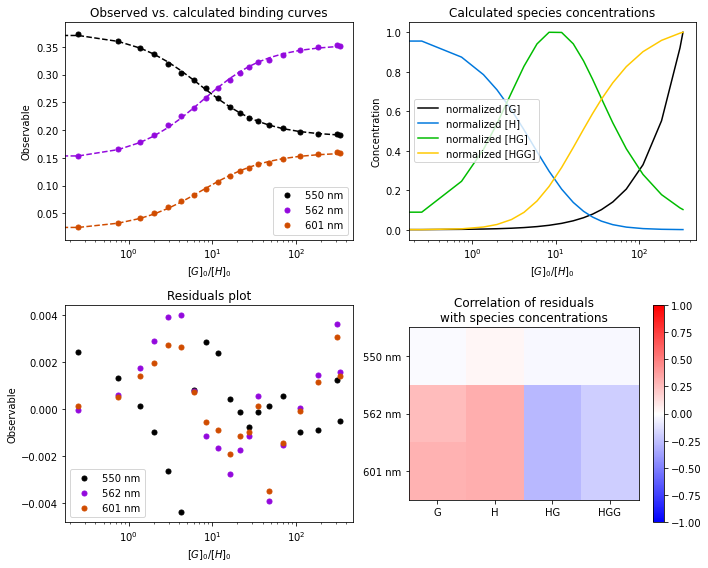

In [8]:
# variables for plots:
x_values = bcf.initial_conc('G')/bcf.initial_conc('H')

# create figure and color maps:
fig, ax = plt.subplots(2, 2, figsize=(10,8))
cmap_obs = mpl.cm.get_cmap('gnuplot')
cmap_conc = mpl.cm.get_cmap('nipy_spectral')
cmap_corr = mpl.cm.get_cmap('bwr')

# generate results plot:
for index, obs in enumerate(bcf.observed_at):
    cval = float(index / bcf.num_observables)
    ax[0][0].semilogx(x_values, bcf.bindcurv_calc(obs), color=cmap_obs(cval), linestyle='dashed')
    ax[0][0].semilogx(x_values, bcf.bindcurv_exp(obs), color=cmap_obs(cval), linestyle='none',
                marker='o', markerfacecolor=cmap_obs(cval), markersize=5, label=obs)
ax[0][0].set_title('Observed vs. calculated binding curves')
ax[0][0].set_xlabel(r'$[G]_{0}/[H]_{0}$')
ax[0][0].set_ylabel('Observable')
ax[0][0].legend()

# generate concentrations plot:
for index, spec in enumerate(bcf.species_names):
    cval = float(index / bcf.num_species)
    ax[0][1].semilogx(x_values, bcf.equilibrium_conc(spec) / bcf.equilibrium_conc(spec).max(),
                      color=cmap_conc(cval), linestyle='solid', label=f'normalized [{spec}]')
ax[0][1].set_title('Calculated species concentrations')
ax[0][1].set_xlabel(r'$[G]_{0}/[H]_{0}$')
ax[0][1].set_ylabel('Concentration')
ax[0][1].legend()

# generate error plot:
for index, obs in enumerate(bcf.observed_at):
    cval = float(index / bcf.num_observables)
    ax[1][0].semilogx(x_values, bcf.bindcurv_residuals(obs), color=cmap_obs(cval), linestyle='none',
                marker='o', markerfacecolor=cmap_obs(cval), markersize=5, label=obs)
ax[1][0].set_title('Residuals plot')
ax[1][0].set_xlabel(r'$[G]_{0}/[H]_{0}$')
ax[1][0].set_ylabel('Observable')
ax[1][0].legend()

# plot correlation heat map:
heatmap = ax[1][1].imshow( bcf.correlation_coeff('float'), cmap=cmap_corr, vmin=-1., vmax=1. )
fig.colorbar(heatmap)
ax[1][1].set_xticks(np.arange(bcf.num_species))
ax[1][1].set_yticks(np.arange(bcf.num_observables))
ax[1][1].set_xticklabels(bcf.species_names)
ax[1][1].set_yticklabels(bcf.observed_at)
ax[1][1].set_title('Correlation of residuals\nwith species concentrations')

# remove overlaps between title and labels:
plt.tight_layout()

Beautiful! That worked :)

Now clone or download this repository and start playing with it yourself.